In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
#Importando os dados

df_ab = pd.read_csv('ab_data.csv')

#Verificando os usuários que aparecem mais de uma vez
df_ab_aux = df_ab.groupby('user_id').agg('count')

df_ab_aux = df_ab_aux.loc[df_ab_aux['timestamp'] > 1]

df_ab_aux = df_ab_aux.index

#Como não sabemos quais das sessões destes usuários vamos considerar e o número de usuários duplicados é pequeno
#(3894 em um dataframe de 294478 entradas) podemos descartar esses usuários

df_ab = df_ab[~df_ab['user_id'].isin(df_ab_aux)]



In [3]:
#Criando as tabelas de controle e tratamento
df_control = df_ab.loc[df_ab['group'] == 'control']
df_treat = df_ab.loc[df_ab['group'] == 'treatment']

#Verificando se no grupo de controle todos foram direcionados para a página antiga
df_control_aux = df_control['group'].drop_duplicates()
df_control_aux
df_control_aux.info()

#Verificando se no grupo de tratamento todos foram direcionados para a página nova
df_treat_aux = df_treat['group'].drop_duplicates()
df_treat_aux
df_treat_aux.info()

#Definindo o tamanho das amostras que vamos usar para cada grupo
#É preciso definir a diferença que queremos ver entre as taxas de conversão das páginas
#Para isso, primeiro precisamos calcular a proporção de conversões por acessos no grupo de controle

numero_conv = df_control['converted'].agg('sum')
numero_total = df_control['converted'].agg('count')
taxa_conversao_atual = numero_conv/numero_total

#Calculamos a taxa de conversão atual = 0.12017335110577627, que vamos considerar 12% para a administração do negócio

#O efeito mínimo desejado é um parâmetro do negócio
#Neste caso vamos supor que os diretores esperam que a nova página aumente em 5%, ou seja, taxa de conversão = 17%

efeito = sms.proportion_effectsize(0.12, 0.17)

n_amostra = sms.NormalIndPower().solve_power(
    efeito, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)            
n_amostra = ceil(n_amostra)

#Quanto menor a diferença (efeito), maior será o tamanho da amostra, pois o teste precisa ser mais sensível
#Com os parâmetros escolhidos acima, cada amostra terá 774 observações
#Em uma situação real, isso quer dizer que a página antiga seria mostrada para outros 774 usuários
#E a página nova seria mostrada para outros 774 usuários para que seja possível tirar alguma conclusão

print(n_amostra)

<class 'pandas.core.series.Series'>
Int64Index: 1 entries, 0 to 0
Series name: group
Non-Null Count  Dtype 
--------------  ----- 
1 non-null      object
dtypes: object(1)
memory usage: 16.0+ bytes
<class 'pandas.core.series.Series'>
Int64Index: 1 entries, 2 to 2
Series name: group
Non-Null Count  Dtype 
--------------  ----- 
1 non-null      object
dtypes: object(1)
memory usage: 16.0+ bytes
774


In [4]:
#Nós já temos muito mais entradas de dados do que as 774 para cada grupo, mas para simular uma situação real
#Vamos selecionar aleatóriamente amostras deste tamanho para análise
#Pois, em uma situação real, colher mais observações leva tempo e pode ser muito caro

#Amostra do grupo de controle (página antiga)
amostra_control = df_control.sample(n=n_amostra, random_state=42)

#Amostra do grupo de tratamento (página nova)
amostra_treat = df_treat.sample(n=n_amostra, random_state=42)

#O random_state é apenas uma das possibilidades de aleatoriedade (vai de 0 a 2^32 - 1 = 4294967295)


#Calculando a taxa de conversão de cada amostra
numero_conv_control = amostra_control['converted'].agg('sum')
taxa_conversao_control = numero_conv_control/n_amostra
print(f'A média amostral do grupo de controle é {np.round(taxa_conversao_control*100,2)}%')

numero_conv_treat = amostra_treat['converted'].agg('sum')
taxa_conversao_treat = numero_conv_treat/n_amostra
print(f'A média amostral do grupo de tratamento é {np.round(taxa_conversao_treat*100,2)}%')

#Desde já conseguimos avaliar que não houve um aumento de 5% nas conversões, como a diretoria espera
#Mas a pergunta feita em um teste A/B é, sobretudo, se houve uma mudança significativa na distribuição

#Calculando o desvio padrão de cada amostra
#ddof significa degrees od freedom, ou graus de liberdade e o valor 0 indica que estamos lidando com observações unitárias
#para calcular o desvio padrão em um experimento em que cada observação é uma média amostral, usamos ddof = 1

dp_control = np.std(amostra_control['converted'], ddof = 0)
print(f'O desvio padrão da amostra de controle é {np.round(dp_control*100,2)}%')

dp_treat = np.std(amostra_treat['converted'], ddof = 0)
print(f'O desvio padrão da amostra de tratamento é {np.round(dp_treat*100,2)}%')

#Realizando o teste
z_stat, pval = proportions_ztest([numero_conv_control,numero_conv_treat], nobs=[n_amostra, n_amostra])
#Calculando os intervalos de confiança
(inf_con, inf_treat), (sup_con, sup_treat) = proportion_confint([numero_conv_control,numero_conv_treat], [n_amostra, n_amostra], alpha=0.05)

print(f'z: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'intervalo de confiança 95% para o grupo de controle: [{inf_con:.3f}, {sup_con:.3f}]')
print(f'intervalo de confiança 95% para o grupo de tratamento: [{inf_treat:.3f}, {sup_treat:.3f}]')



A média amostral do grupo de controle é 11.5%
A média amostral do grupo de tratamento é 13.95%
O desvio padrão da amostra de controle é 31.9%
O desvio padrão da amostra de tratamento é 34.65%
z: -1.45
p-value: 0.147
intervalo de confiança 95% para o grupo de controle: [0.093, 0.137]
intervalo de confiança 95% para o grupo de tratamento: [0.115, 0.164]


In [5]:
#Avaliando os resultados

#O p-value ficou acima do 0,05, que era o parâmetro alpha, ou a chance de cometermos um erro do tipo 1
#Erro do tipo 1: consdierar que a distribuição do grupo de tratamento é diferente que a dist do grupo de controle
#Dessa forma não podemos rejeitar a hipótese nula de que as duas amostras seguem a mesma distribuição
#Ou seja, não houve diferença significativa de performance entre as duas páginas
#Nem para melhor nem para pior
#Muito menos podemos afirmar que houve um aumento de 5%, como esperado pela diretoria
#Apesar da média amostral ser maior para o grupo de tratamento, isso não tem significância estatística
#Em um cenário de negócios data-driven, essa nova página não seria lançada ao público

In [6]:
#Bônus: avaliando a população total

#Vamos agora usar toda a informação do dataset original e considerar que esses são todos os acessos ao site
#Já dividimos entre os usuários que foram direcionados à página nova e à pagina antiga
#Contudo, deixar essa divisão aqui também permite que essa célula seja executada múltiplas vezes
#Sem precisar executar o código anterior

df_control = df_ab.loc[df_ab['group'] == 'control']
df_treat = df_ab.loc[df_ab['group'] == 'treatment']

#O objetivo é pegar o máximo número de amostras de tamanho n de cada grupo e observar a distribuição das médias amostrais
#Lembrando que médias amostrais sempre tendem a uma distribuição normal (ou Gaussiana)
#Mantendo n = 774
#Verificar quantas amostras deste tamanho podem ser retiradas de cada grupo

df_control_cont = df_control['converted'].agg('count')
numero_de_amostras_control = floor(df_control_cont/n_amostra)

df_treat_cont = df_treat['converted'].agg('count')
numero_de_amostras_treat = floor(df_treat_cont/n_amostra)

print(f'{numero_de_amostras_control}, {numero_de_amostras_treat}')

medias_control = pd.Series(index = (1, 185), dtype = 'float64')
medias_treat = pd.Series(index = (1, 185), dtype = 'float64')

contador = 1

for contador in range(1, numero_de_amostras_control+1):
    amostra_control = df_control.sample(n=n_amostra, random_state=42)
    users = amostra_control['user_id']
    conv = amostra_control['converted'].agg('sum')
    media = conv/n_amostra
    medias_control[contador] = media
    #Retirando as observações já consideradas
    df_control = df_control[~df_control['user_id'].isin(users)]
    
for contador in range(1, numero_de_amostras_treat+1):
    amostra_treat = df_treat.sample(n=n_amostra, random_state=42)
    users = amostra_treat['user_id']
    conv = amostra_treat['converted'].agg('sum')
    media = conv/n_amostra
    medias_treat[contador] = media
    #Retirando as observações já consideradas
    df_treat = df_treat[~df_treat['user_id'].isin(users)]
    
    
    
    

185, 185


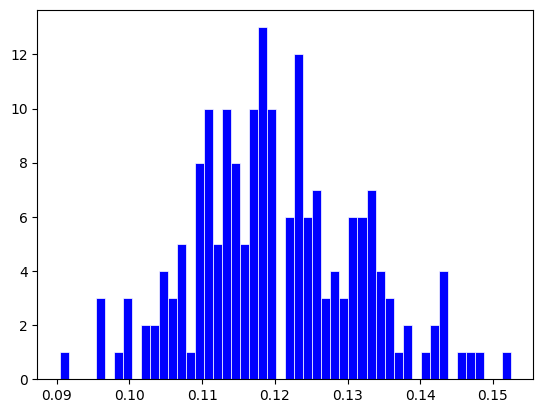

A média amostral do grupo de controle é 0.1202
O desvio padrão amostral do grupo de controle é 1.14%


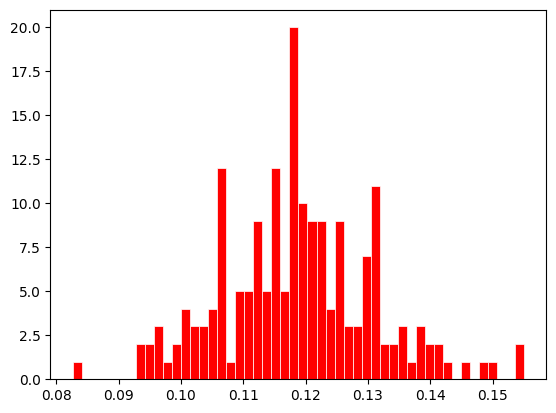

A média amostral do grupo de tratamento é 0.1187
O desvio padrão amostral do grupo de tratamento é 1.22%


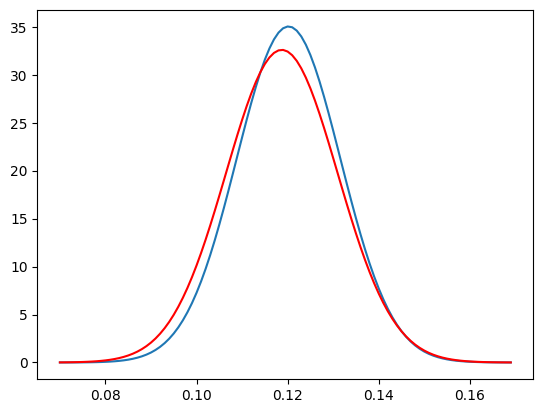

In [32]:
#Vizualização das distribuições amostrais

fig, ax = plt.subplots()

ax.hist(medias_control, bins=50, linewidth=0.5, edgecolor="white", color= 'blue')

plt.show()

plt.close()


media_amostral_control = np.mean(medias_control)
print(f'A média amostral do grupo de controle é {np.round(media_amostral_control,4)}')

dp_amostral_control = np.std(medias_control, ddof = 1)
print(f'O desvio padrão amostral do grupo de controle é {np.round(dp_amostral_control*100,2)}%')


fig, ax = plt.subplots()

ax.hist(medias_treat, bins=50, linewidth=0.5, edgecolor="white", color= 'red')

plt.show()

plt.close()

media_amostral_treat = np.mean(medias_treat)
print(f'A média amostral do grupo de tratamento é {np.round(media_amostral_treat,4)}')

dp_amostral_treat = np.std(medias_treat, ddof = 1)
print(f'O desvio padrão amostral do grupo de tratamento é {np.round(dp_amostral_treat*100,2)}%')


# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0.07, 0.17, 0.001)
  
plt.plot(x_axis, stats.norm.pdf(x_axis, media_amostral_control, dp_amostral_control))
plt.plot(x_axis, stats.norm.pdf(x_axis, media_amostral_treat, dp_amostral_treat), color ='red')

plt.show()
